# YOLOv5_alumnos - Deteccion de Objetos Personalizada
**Asignatura:** Programacion con IA  
**Proyecto:** SENTINEL HUD (Seguridad industrial con deteccion de EPIs)  
**Alumno:** Diego Sanchez  
**Fecha:** 14/02/2026


## 1. Definicion del problema
Se plantea un sistema de deteccion de objetos para mejorar la seguridad en entornos industriales.  
El problema concreto es detectar automaticamente incumplimientos de EPI y zonas/objetos de riesgo en imagenes de planta.

Clases objetivo del detector:
- `Casco`
- `Chaleco`
- `Persona_Sin_Equipo`
- `Peligro`

Uso esperado: monitorizacion automatica y alerta temprana para reducir supervision manual y riesgo operativo.


## 2. Creacion / obtencion del dataset
Se utilizo un dataset propio en formato YOLO (`images/` + `labels/`) con split train/val.

Resumen del dataset final:
- Imagenes train: **138**
- Etiquetas train: **138**
- Imagenes val: **38**
- Etiquetas val: **38**
- Clases: **4**

Archivo de configuracion: `dataset_final/custom_data.yaml`


In [1]:
# Estructura y YAML del dataset
from pathlib import Path
import yaml

yaml_path = Path('dataset_final/custom_data.yaml')
print(yaml_path.read_text(encoding='utf-8'))


names:
- Casco
- Chaleco
- Persona_Sin_Equipo
- Peligro
nc: 4
path: ../dataset_final
train: images/train
val: images/val



## 3. Proceso de entrenamiento del modelo (paso a paso)
1. Se clono el repositorio oficial de YOLOv5 y se instalaron dependencias.
2. Se configuro el dataset custom (`dataset_final/custom_data.yaml`) con 4 clases.
3. Se aplico fine-tuning desde pesos preentrenados (`yolov5s.pt`).
4. Se entreno con imagenes de 640 px y `batch=8` para equilibrar consumo de RAM y estabilidad.
5. Se habilito `--cache` para reducir I/O de disco durante entrenamiento.
6. Se guardaron automaticamente `best.pt` (mejor mAP@0.5 en validacion interna) y `last.pt`.

Hardware verificado:
- `nvidia-smi`: GPU fisica disponible (RTX 2070)
- `torch.cuda.is_available()`: `False` (entorno con `torch 2.10.0+cpu`)

Conclusiones de entorno:
- El entrenamiento se ejecuto 100% en CPU.
- Por esta limitacion se uso una corrida de 10 epocas para mantener tiempos razonables.


```bash
python yolov5/train.py \
  --img 640 \
  --batch 8 \
  --epochs 10 \
  --data dataset_final/custom_data.yaml \
  --weights yolov5s.pt \
  --cache \
  --project yolov5/runs_academic \
  --name actividad1_10e
```


## 4. Informe de resultados del modelo
### 4.1 Datos objetivos (metricas)
Fuente primaria de metricas globales por epoca: `yolov5/runs_academic/actividad1_10e/results.csv`

Coherencia verificada entre entrenamiento y validacion:
- Mejor epoca por `mAP@0.5`: **8**
- Mejor epoca por `mAP@0.5:0.95`: **9**

Metricas de la epoca 8 (seleccion de `best.pt` por mAP@0.5):
- Precision: **0.251**
- Recall: **0.395**
- mAP@0.5: **0.322**
- mAP@0.5:0.95: **0.111**

Metricas de la ultima epoca (epoca 9):
- Precision: **0.241**
- Recall: **0.268**
- mAP@0.5: **0.305**
- mAP@0.5:0.95: **0.111**

Control de reproducibilidad de validacion (`best.pt`):
- `batch=16` (`yolov5/runs_academic/audit_val_bs16_log.txt`): all P=0.251, R=0.396, mAP50=0.322, mAP50-95=0.111.
- `batch=32` (`yolov5/runs_academic/audit_val_bs32_log.txt`): all P=0.222, R=0.414, mAP50=0.283, mAP50-95=0.107.

Interpretacion metodologica:
- En este dataset pequeno (38 imagenes de validacion), la metrica presenta sensibilidad al tamano de lote en `val.py`.
- Para consistencia academica, las metricas reportadas se anclan en `results.csv` y en la revalidacion `batch=16`, que coincide con la seleccion de `best.pt`.


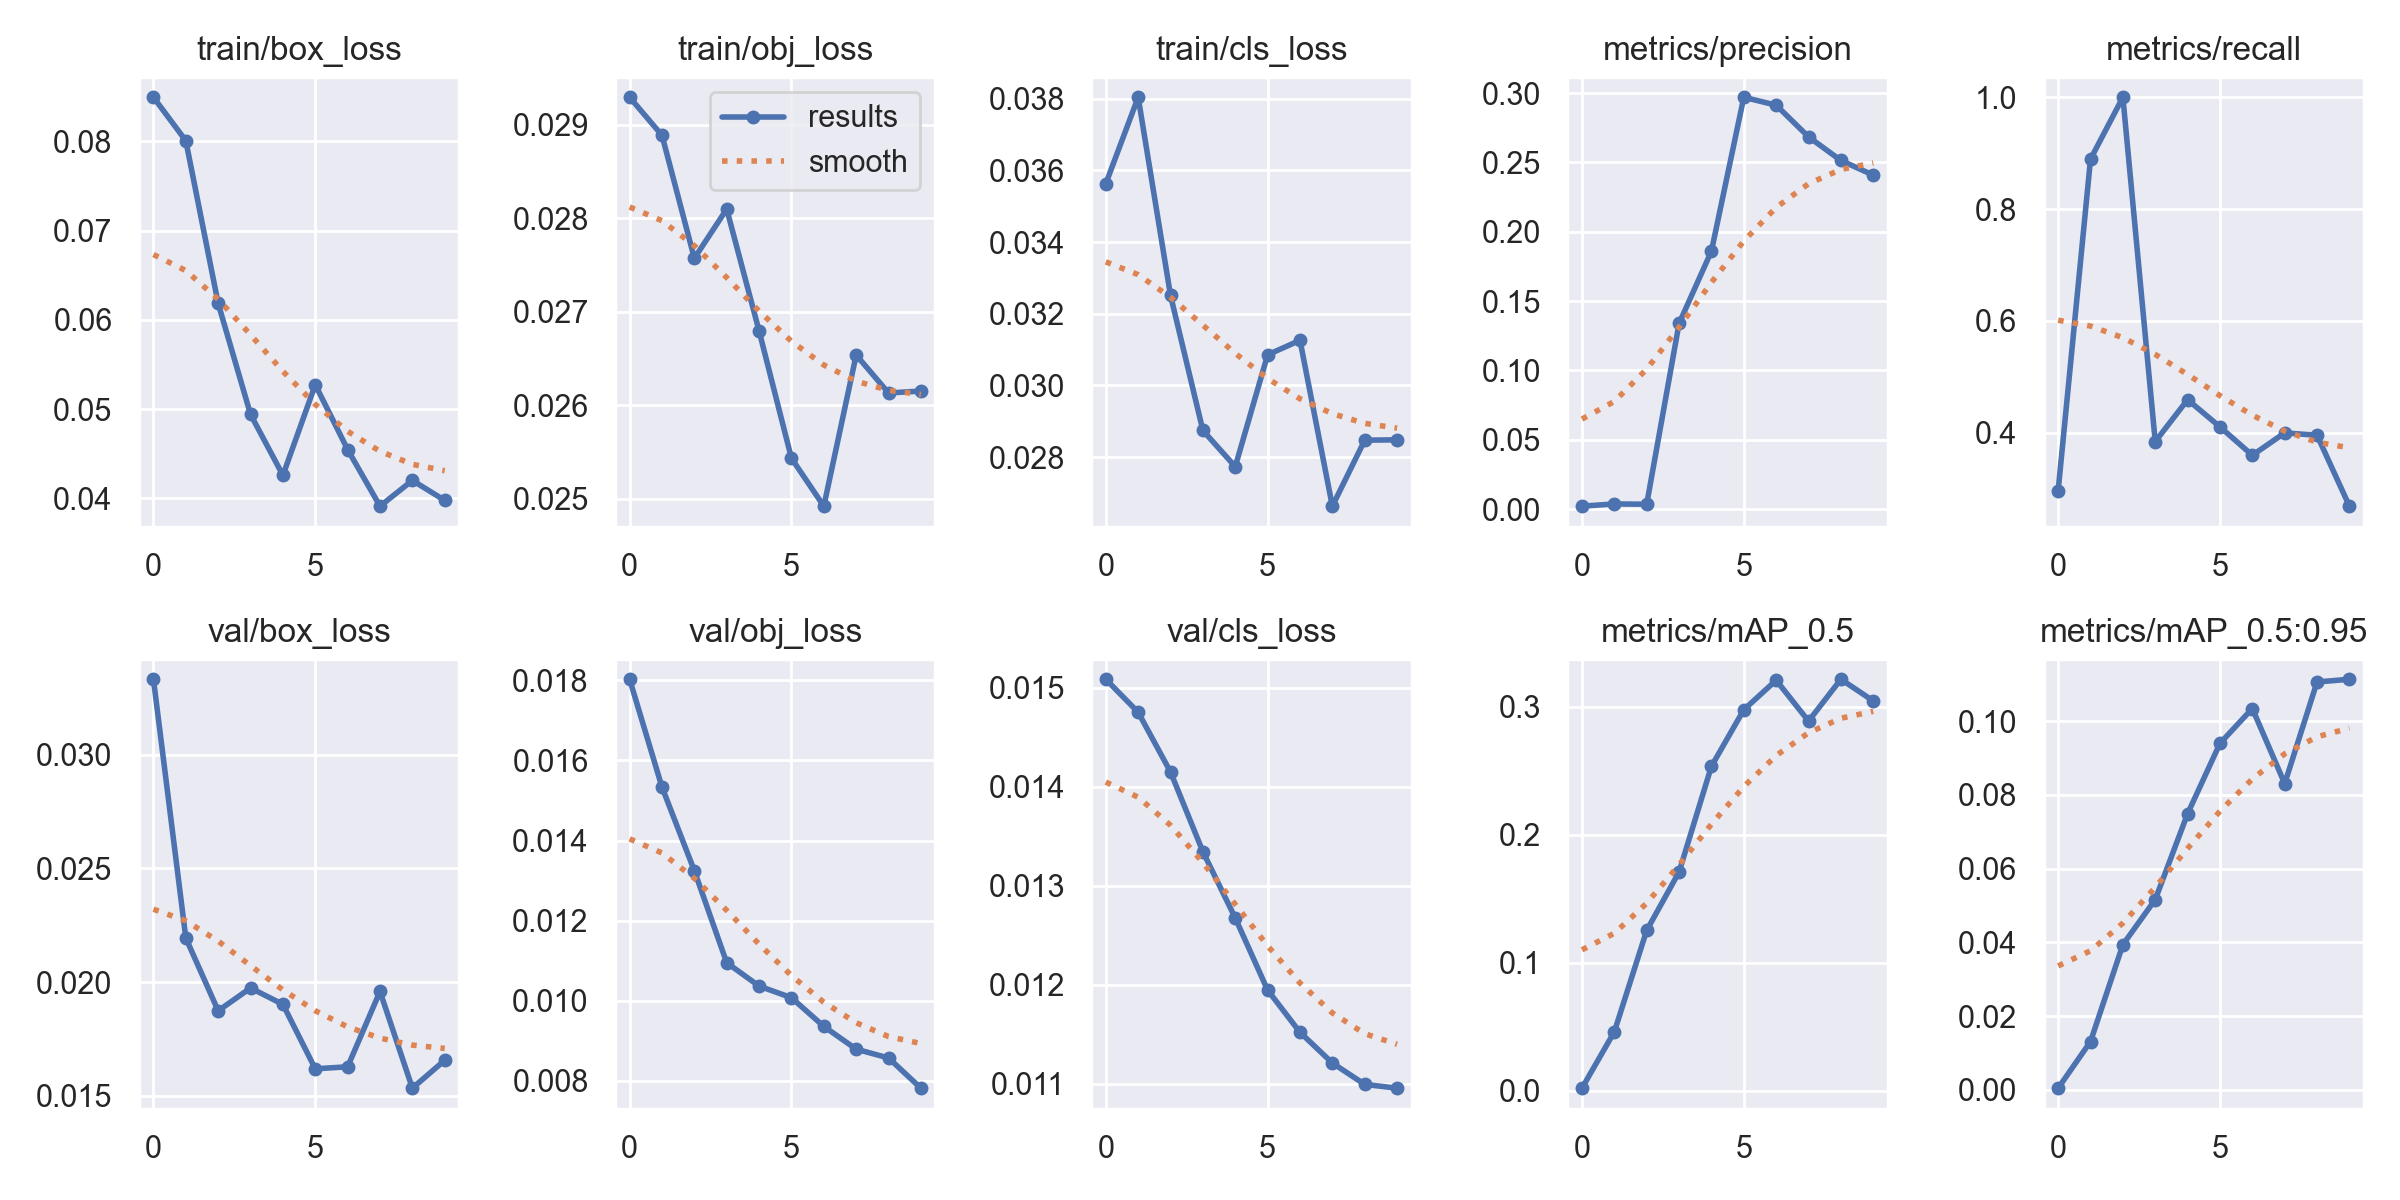

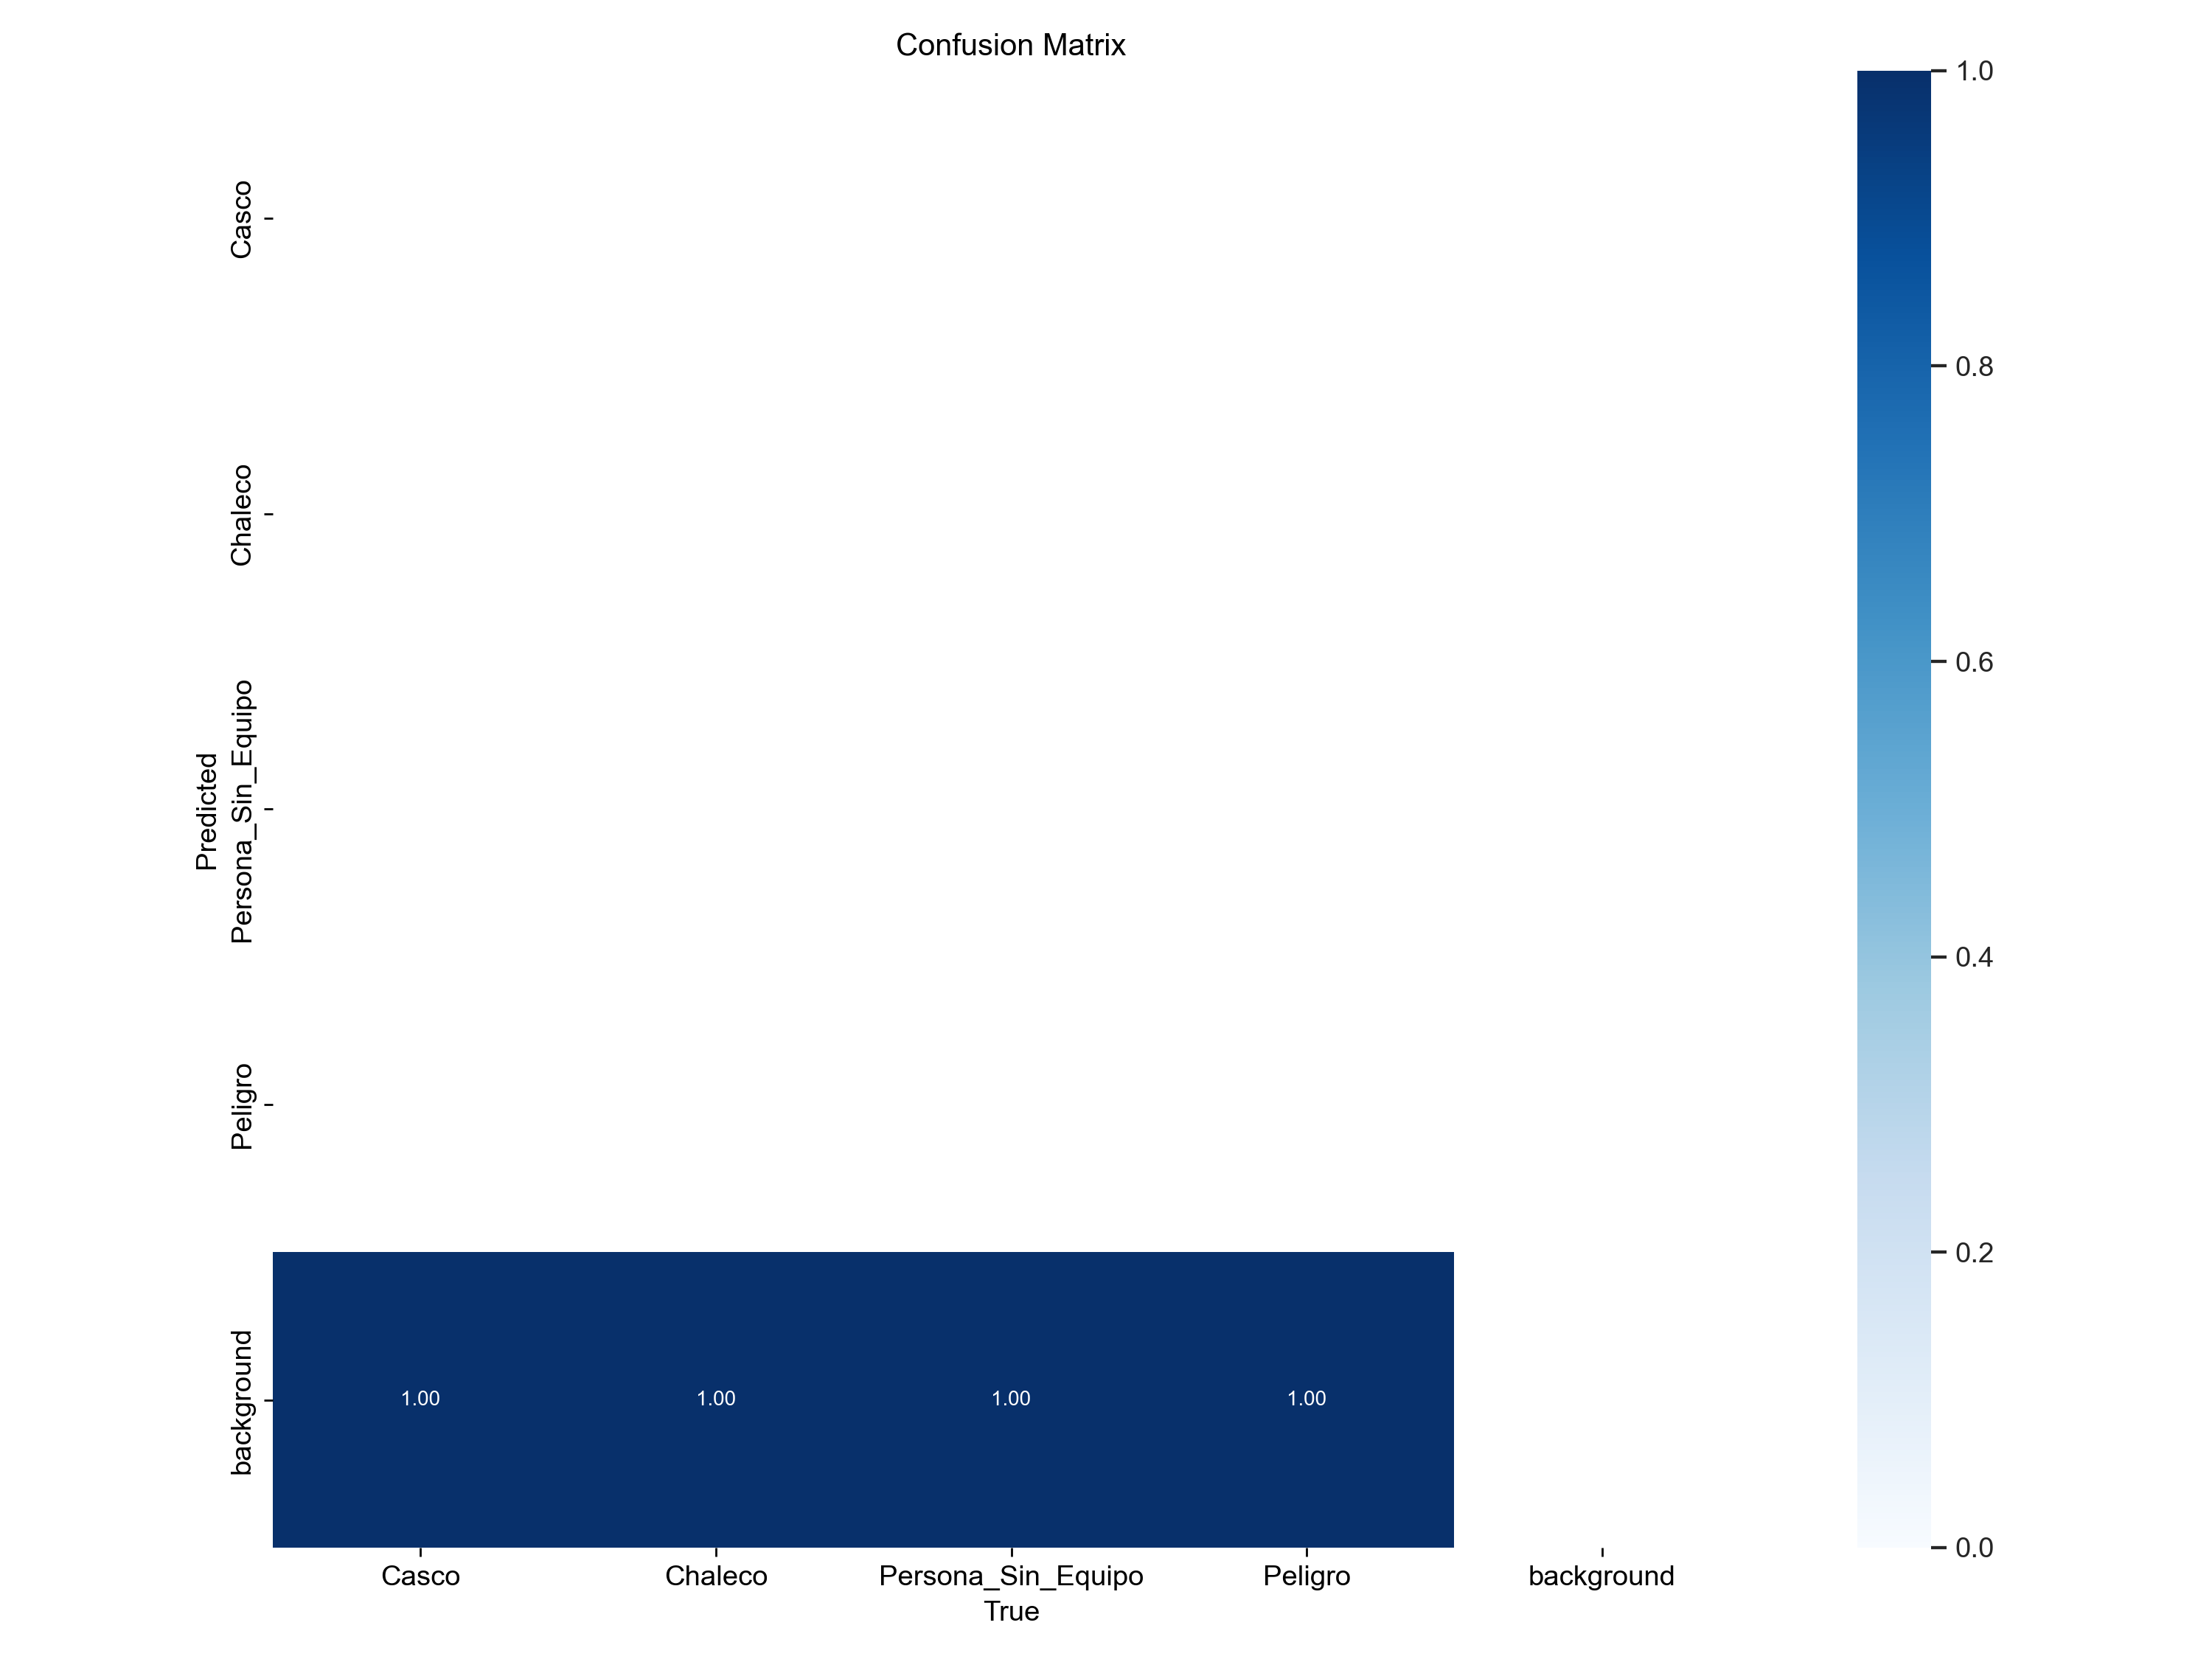

In [2]:
# Curvas y matriz de confusion generadas por YOLOv5
from IPython.display import Image, display

display(Image(filename='yolov5/runs_academic/actividad1_10e/results.png', width=900))
display(Image(filename='yolov5/runs_academic/val_actividad1_bs16/confusion_matrix.png', width=650))


### 4.2 Metricas por clase (validacion final coherente con best.pt)
Fuente: `yolov5/runs_academic/audit_val_bs16_log.txt`

- all: P=0.251, R=0.396, mAP50=0.322, mAP50-95=0.111
- Casco: P=0.562, R=0.352, mAP50=0.395, mAP50-95=0.110
- Chaleco: P=0.259, R=0.600, mAP50=0.452, mAP50-95=0.154
- Persona_Sin_Equipo: P=0.0772, R=0.132, mAP50=0.102, mAP50-95=0.0385
- Peligro: P=0.108, R=0.500, mAP50=0.337, mAP50-95=0.141

### 4.3 Analisis tecnico critico
Lectura profesional de mAP@0.5 vs mAP@0.5:0.95:
- `mAP@0.5` confirma capacidad de deteccion con criterio IoU permisivo.
- `mAP@0.5:0.95` penaliza la localizacion fina de caja (IoU altos), por eso cae a 0.111.
- La brecha (0.322 vs 0.111) indica detector funcional, pero aun lejos de una precision espacial robusta.

Convergencia, overfitting y underfitting:
- `train/box_loss`: 0.0849 -> 0.0398 (**-53.2%**).
- `val/box_loss`: 0.0333 -> 0.0166 (**-50.3%**).
- `val/obj_loss`: 0.0180 -> 0.0078 (**-56.6%**).
- No hay divergencia train-val sostenida, por lo que **no** hay evidencia fuerte de overfitting en 10 epocas.
- Si hay evidencia de **underfitting parcial**: la localizacion fina sigue baja (mAP50-95=0.111) y la metrica por clase critica sigue debil.

Diagnostico por clase y dataset:
- `Persona_Sin_Equipo` es el cuello de botella real (mAP50=0.102, R=0.132).
- El dataset esta casi balanceado por clase en train (32-36 instancias/clase), pero el volumen total es bajo (138 instancias train, 38 val).
- En validacion, `Persona_Sin_Equipo` tiene solo 7 instancias, lo que eleva varianza estadistica y vuelve inestable la comparacion de modelos.

Debilidades tecnicas objetivas de la entrega actual:
- Validacion final sin set externo no visto (se usan muestras del split val en inferencia cualitativa).
- Falta de analisis de sensibilidad experimental (seed, workers, batch, TTA) para robustez de conclusiones.
- Entrenamiento corto para un diagnostico de convergencia completa (10 epocas con 3 de warmup).

Mejoras realistas para subir a nivel 10:
- Crear test set externo (20-40 imagenes) y reportar metricas separadas de val.
- Aumentar datos de `Persona_Sin_Equipo` en escenarios dificiles (occlusion, escala, contraluz, poses).
- Probar 50 epocas en CUDA con early stopping y comparar contra baseline 10 epocas.
- Ajustar hiperparametros focalizados en localizacion (`scale`, `translate`, `iou_t`, `anchor_t`) con protocolo fijo de validacion.
- Repetir validacion con semilla fija y `workers=0` para reducir variabilidad de medicion en CPU.


## 5. Inferencia del modelo
Se ejecuto inferencia con `best.pt` para inspeccion cualitativa de predicciones.

Comando de inferencia:


```bash
python yolov5/detect.py \
  --weights yolov5/runs_academic/actividad1_10e/weights/best.pt \
  --img 640 \
  --conf 0.10 \
  --source inference_samples_val \
  --project yolov5/runs_academic \
  --name inferencia_actividad1_val
```


Ejemplos de salidas guardadas en `yolov5/runs_academic/inferencia_actividad1_val/`.

Observacion metodologica:
- Esta inferencia se realizo sobre una muestra del split de validacion (`inference_samples_val`).
- Por rigor experimental, para una evaluacion final de despliegue se recomienda un set externo no visto (dominio distinto o captura propia).

Archivos ejemplo:
- Casco_12.jpg
- Casco_19.jpg
- Casco_7.jpg
- Chaleco_26.jpg


Casco_12.jpg


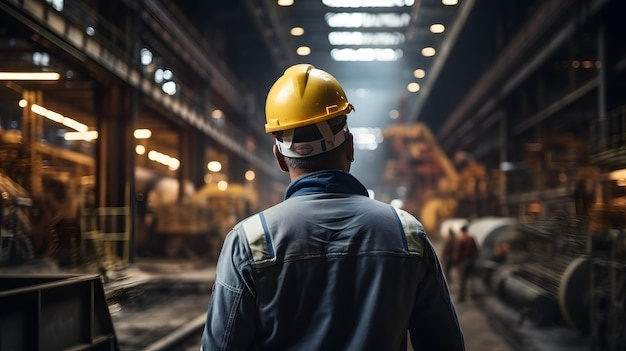

Casco_19.jpg


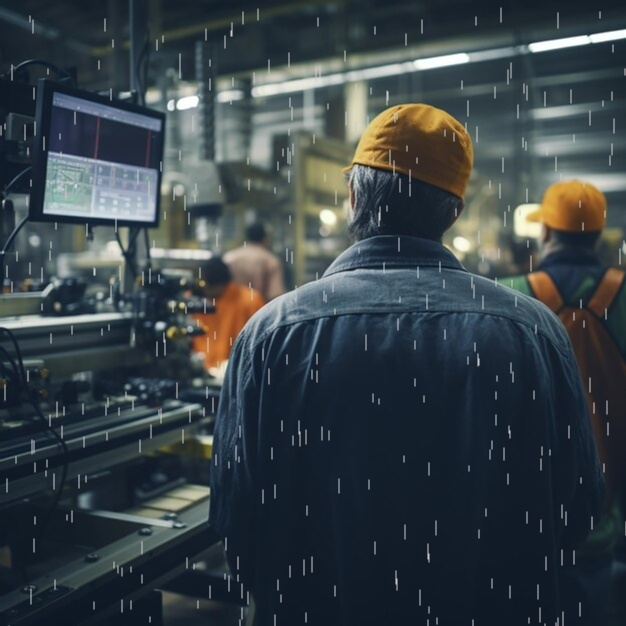

Casco_7.jpg


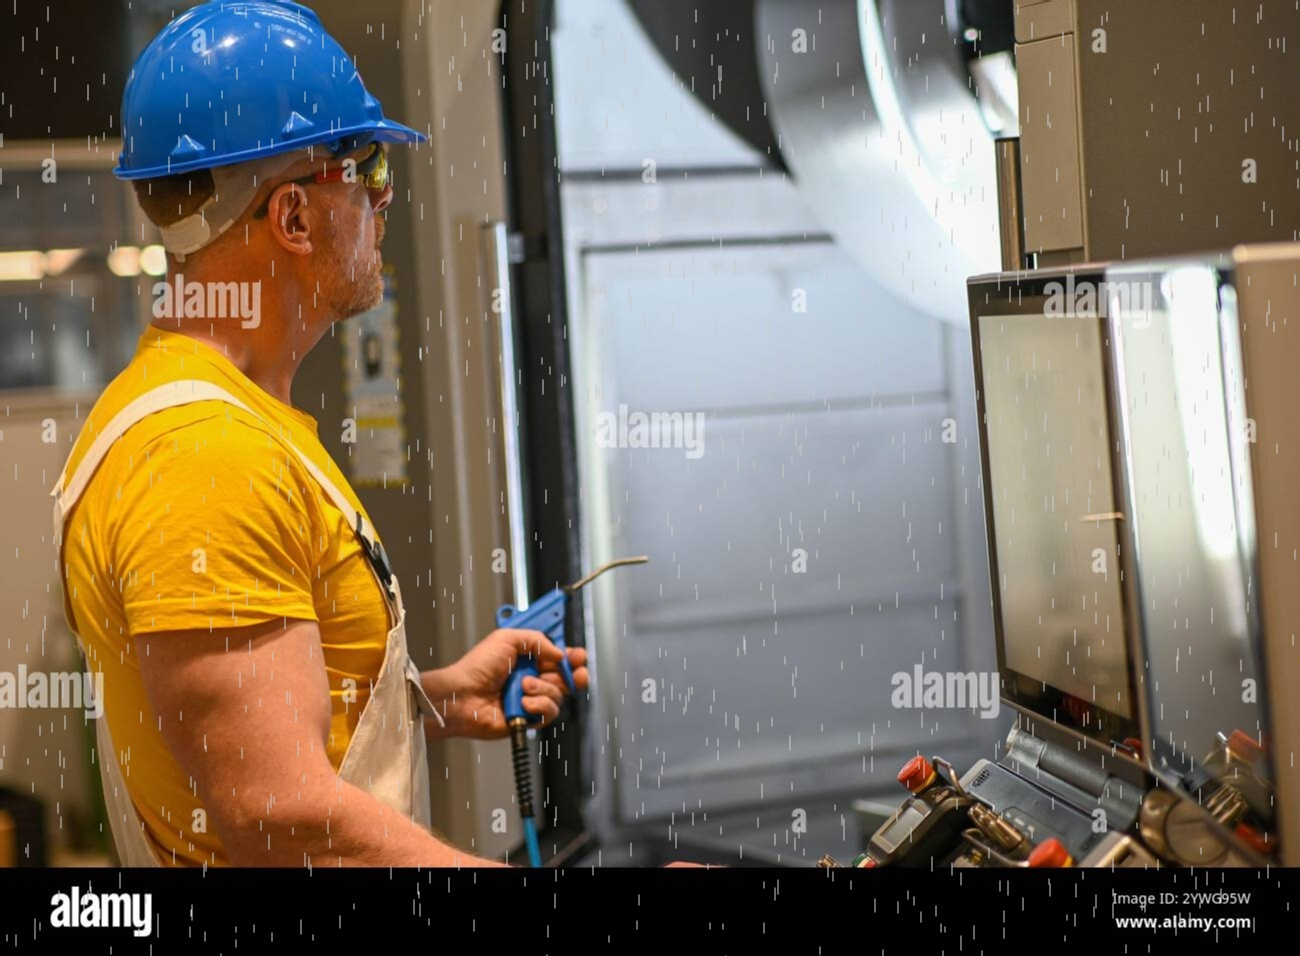

Chaleco_26.jpg


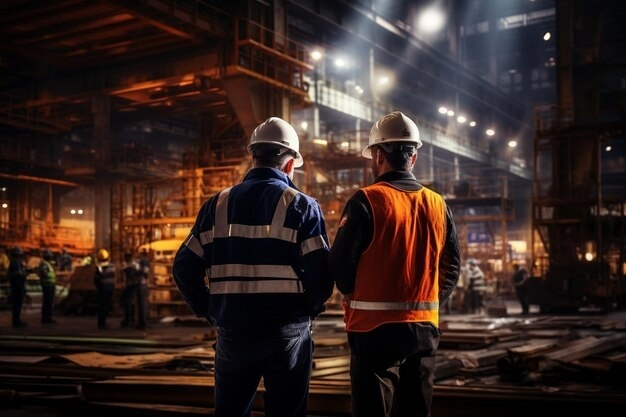

In [3]:
# Visualizar ejemplos de prediccion
from pathlib import Path
from IPython.display import Image, display

pred_dir = Path('yolov5/runs_academic/inferencia_actividad1_val')
for p in sorted(pred_dir.glob('*.jpg'))[:4]:
    print(p.name)
    display(Image(filename=str(p), width=650))


## 6. Conclusiones y continuidad
Evaluacion academica honesta:
- La entrega esta bien estructurada y cumple trazabilidad de pipeline completo.
- El rendimiento es **aceptable** para una primera iteracion, pero aun no sobresaliente en la clase mas critica.
- Con la evidencia actual, esta entrega se ubica en un rango estimado de **8.7/10**.

Decision tecnica sobre 10 vs 50 epocas:
- **Recomendacion: ampliar a 50 epocas (justificado).**
- Motivos: no hay overfitting claro, la loss de validacion sigue bajando, y la precision espacial (`mAP@0.5:0.95`) sigue limitada.
- Impacto esperado: mejora **moderada** (no milagrosa), especialmente en localizacion y estabilidad de metricas por clase.

Plan academico propuesto para la corrida de 50 epocas:
1. Entrenar: `python yolov5/train.py --img 640 --batch 8 --epochs 50 --data dataset_final/custom_data.yaml --weights yolov5s.pt --cache --project yolov5/runs_academic --name actividad1_50e --exist-ok`
2. Validar en configuracion fija (`batch=16`, semilla fija) y guardar log textual.
3. Comparar 10e vs 50e en tabla unica: P, R, mAP50, mAP50-95 global + por clase.
4. Actualizar automaticamente notebook y PDF con rutas nuevas (`actividad1_50e`, `val_actividad1_50e`) sin modificar resultados historicos.

Criterio de cierre:
- Si 50 epocas no mejora al menos la clase critica (`Persona_Sin_Equipo`) y `mAP@0.5:0.95`, la prioridad debe pasar de "mas epocas" a "mas y mejores datos".
